In [1]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

/Users/adi/opt/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/adi/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/adi/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <42C20470-F879-3070-BF42-74C7B230A1A1> /Users/adi/opt/anaconda3/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# from my utils notebook
def add_to_class(Class):
    """Register them functions"""
    def wrapper(obj):
        # setattr(object, name, value) -> sets the value of the attribute
        setattr(Class ,obj.__name__ , obj)
    return wrapper

In [3]:
class RedWebDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Root Dir is REDWEB_V1
            Imgs -> Monocular Images
            RDs -> Corresponding Response (Heatmap)
        """
        self.root_dir = root_dir
        self.transform = transform
        self.monocular_folder = os.path.join(root_dir, 'Imgs')
        self.heatmap_folder = os.path.join(root_dir, 'RDs')
        # Monocular images are in jpgs and the heatmap images are in pngs
        self.monocular_images = sorted(os.listdir(self.monocular_folder))
        self.heatmap_images = sorted(os.listdir(self.heatmap_folder))


In [4]:
loader = RedWebDataset("../ReDWeb_V1")
loader.monocular_images[:2]

['10147759665_3367509158.jpg', '10147764085_481cd7d72f.jpg']

In [5]:
loader.heatmap_images[:2]

['10147759665_3367509158.png', '10147764085_481cd7d72f.png']

In [6]:
# add a simple __len__ method
@add_to_class(RedWebDataset)
def __len__(self):
    assert len(self.monocular_images) == len(self.heatmap_images) , "Hein?"
    return len(self.monocular_images)

In [7]:
# now we can call len on our loader
len(loader)

3600

In [8]:
# lets write for practice that makes a subplot which shows 
# image and their coresponding heatmap on a single subplot

@add_to_class(RedWebDataset)
def _show_sample(self ,name = None):
    if name:
        name = name if "." not in name else name.spit(".")[0]
    else:
        # show random index
        rand_index = np.random.randint(low= 0,high =len(self) , size=1).item()
        name = self.monocular_images[rand_index].split(".")[0]
    
    # read images
    # mono_img =  plt.imread(loader.monocular_folder +"/"+ name + ".jpg")
    # heat_img =  plt.imread(loader.heatmap_folder +"/"+ name + ".png")
    mono_img =  io.imread(self.monocular_folder +"/"+ name + ".jpg")
    heat_img =  io.imread(self.heatmap_folder +"/"+ name + ".png")
    # convert heat_img to a 3d image
    heat_img = np.stack([heat_img] * 3, axis=-1)
    
    fig , ax = plt.subplot_mosaic("AB")
    ax["A"].set_title(f"Monocular Image{name}",fontsize=8)
    ax["A"].imshow(mono_img)
    ax["B"].set_title(f"Heatmap Image{name}",fontsize=8)
    ax["B"].imshow(heat_img,cmap="inferno")
    ax["A"].grid(False)
    ax["A"].axis('off')
    ax["B"].grid(False)
    ax["B"].axis('off')
    plt.show()

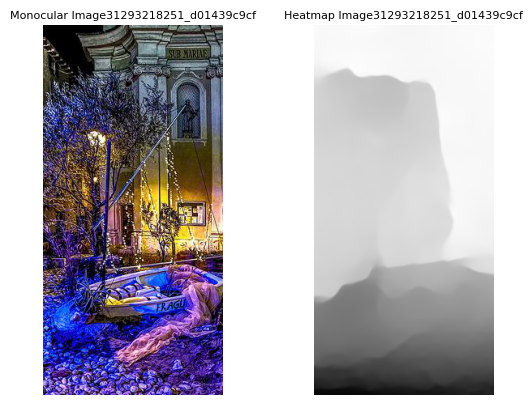

In [9]:
loader._show_sample()

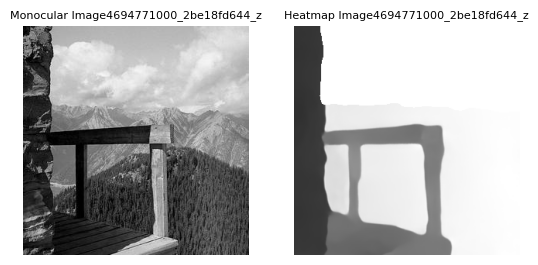

In [10]:
loader._show_sample()

In [11]:
# now lastly just implement __getitem__
@add_to_class(RedWebDataset)
def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
        
    monocular_image = io.imread(self.monocular_folder+"/"+self.monocular_images[idx])
    heatmap_image = io.imread(self.heatmap_folder +"/"+ self.heatmap_images[idx])
    heatmap_image = np.stack([heatmap_image]*3,axis=-1)
    sample = {'mono': monocular_image, 'heat':heatmap_image }

    if self.transform:
        sample = self.transform(sample)

    return sample

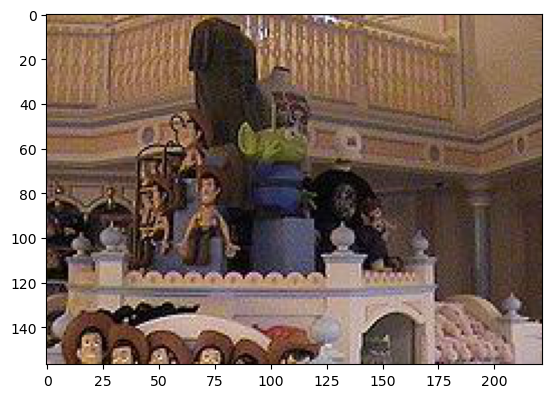

In [12]:
# now we can call index on our loader
plt.imshow(loader[1234]["mono"])

In [13]:
class Rescale(object):
    """
    simple Rescaler for my monocular and heatmap images
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        mono, heat = sample['mono'], sample['heat']
        h, w = mono.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        mono = transform.resize(mono, (new_h, new_w))
        heat = transform.resize(heat, (new_h, new_w))

        return {'mono': mono, 'heat': heat}

In [14]:
rescaler_64 = Rescale((64,64))
scaled = rescaler_64(loader[1234])
m64 ,h64 = scaled["mono"] , scaled["heat"]
print(m64.shape)

(64, 64, 3)


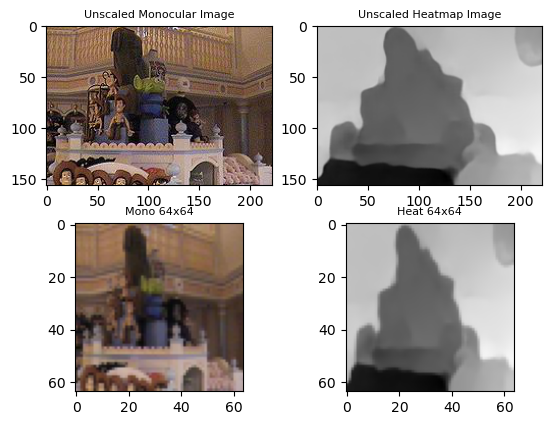

In [15]:
fig , ax = plt.subplot_mosaic("AB;CD")
ax["A"].set_title(f"Unscaled Monocular Image",fontsize=8)
ax["A"].imshow(loader[1234]["mono"])

ax["B"].set_title(f"Unscaled Heatmap Image",fontsize=8)
ax["B"].imshow(loader[1234]["heat"],cmap="inferno")

ax["C"].set_title(f"Mono 64x64",fontsize=8)
ax["C"].imshow(m64)

ax["D"].set_title(f"Heat 64x64",fontsize=8)
ax["D"].imshow(h64,cmap="inferno")


In [16]:
class RandomCrop(object):
    """
    Crop randomly the image in a sample.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        mono, heat = sample['mono'], sample['heat']

        h, w = mono.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        mono = mono[top: top + new_h, left: left + new_w]
        heat = heat[top: top + new_h, left: left + new_w]


        return {'mono': mono, 'heat': heat}


In [17]:
# a random cropper which randomly crops and returns back an image of 64x64
r_cropper = RandomCrop((64,64))
cropped = r_cropper(loader[1234])
cm , ch = cropped["mono"] , cropped["heat"]

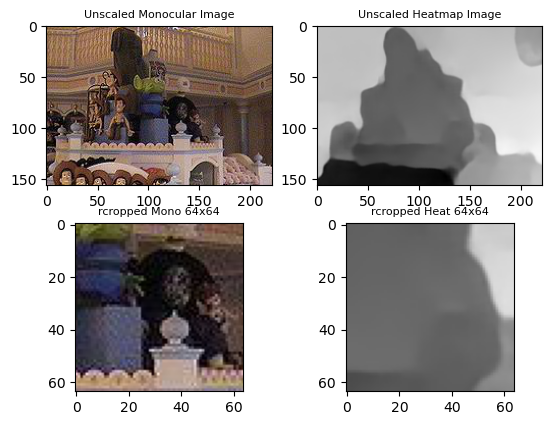

In [18]:
fig , ax = plt.subplot_mosaic("AB;CD")
ax["A"].set_title(f"Unscaled Monocular Image",fontsize=8)
ax["A"].imshow(loader[1234]["mono"])

ax["B"].set_title(f"Unscaled Heatmap Image",fontsize=8)
ax["B"].imshow(loader[1234]["heat"],cmap="inferno")

ax["C"].set_title(f"rcropped Mono 64x64",fontsize=8)
ax["C"].imshow(cm)

ax["D"].set_title(f"rcropped Heat 64x64",fontsize=8)
ax["D"].imshow(ch,cmap="inferno")

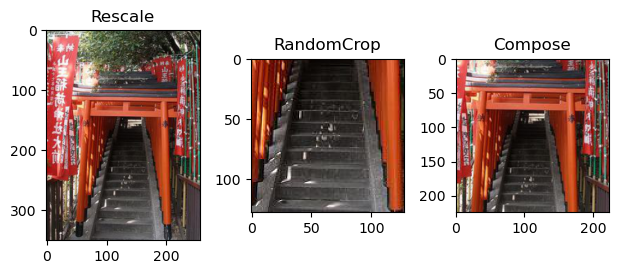

In [19]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = loader[65] # lets start using a different example now
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample["mono"])

plt.show()

In [20]:
# a simple image to tensor class
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        mono, heat = sample['mono'], sample['heat']
        
        # for monocular image :
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        mono = mono.transpose((2, 0, 1))
        heat = heat.transpose((2, 0, 1)) 
        
        return {'mono': torch.from_numpy(mono),
                'heat': torch.from_numpy(heat)}

In [21]:
to_tensor = ToTensor()
tensored= to_tensor(loader[65])
print(type(tensored["mono"]) , type(tensored["heat"]))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [22]:
# and their shape also must be the same in height and width .
# (channel , height , width) <- torch.img
print(tensored["mono"].shape , tensored["heat"].shape)

torch.Size([3, 305, 222]) torch.Size([3, 305, 222])


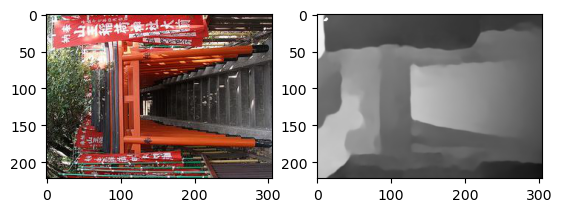

In [23]:
# but that shouldnt change anything .pairwise
# need to plot its transpose as plt.subplots does not take channel as its first dimension
fig,ax = plt.subplot_mosaic("AB")
ax["A"].imshow(tensored["mono"].T)
ax["B"].imshow(tensored["heat"].T,cmap="inferno")

In [24]:
# and now we can iterate through the dataset combining all the operations we have made thus far
transformed_dataset = RedWebDataset(root_dir="../ReDWeb_V1",transform=transforms.Compose([
    Rescale(256),
    RandomCrop(225),
    ToTensor()
]))

sample = transformed_dataset[99]
sample

{'mono': tensor([[[0.4252, 0.4189, 0.4150,  ..., 0.5762, 0.5777, 0.5684],
          [0.4336, 0.4277, 0.4232,  ..., 0.5842, 0.5875, 0.5781],
          [0.4522, 0.4447, 0.4359,  ..., 0.5810, 0.5726, 0.5632],
          ...,
          [0.5108, 0.5085, 0.5162,  ..., 0.5671, 0.6770, 0.5915],
          [0.4918, 0.4890, 0.5042,  ..., 0.5395, 0.5434, 0.5654],
          [0.5063, 0.4979, 0.5064,  ..., 0.5309, 0.5086, 0.5724]],
 
         [[0.5977, 0.5907, 0.5867,  ..., 0.8048, 0.8051, 0.8037],
          [0.6061, 0.6002, 0.5957,  ..., 0.8144, 0.8150, 0.8175],
          [0.6208, 0.6133, 0.6046,  ..., 0.8163, 0.8040, 0.7901],
          ...,
          [0.6834, 0.6841, 0.6926,  ..., 0.7433, 0.8535, 0.7679],
          [0.6657, 0.6651, 0.6826,  ..., 0.7136, 0.7198, 0.7419],
          [0.6823, 0.6764, 0.6867,  ..., 0.7034, 0.6850, 0.7489]],
 
         [[0.1602, 0.1575, 0.1541,  ..., 0.0147, 0.0256, 0.0363],
          [0.1679, 0.1649, 0.1604,  ..., 0.0217, 0.0345, 0.0401],
          [0.1973, 0.1898, 0.181

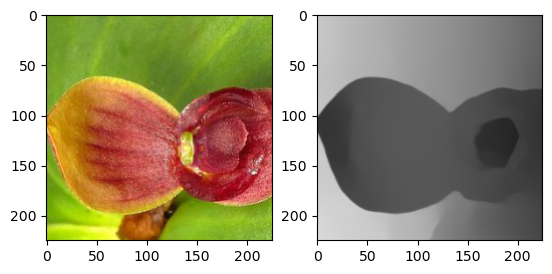

In [25]:
# this is how they look after composing transformations and converting them into tensor objects
fig,ax = plt.subplot_mosaic("AB")
ax["A"].imshow(sample["mono"].T)
ax["B"].imshow(sample["heat"].T,cmap="inferno")

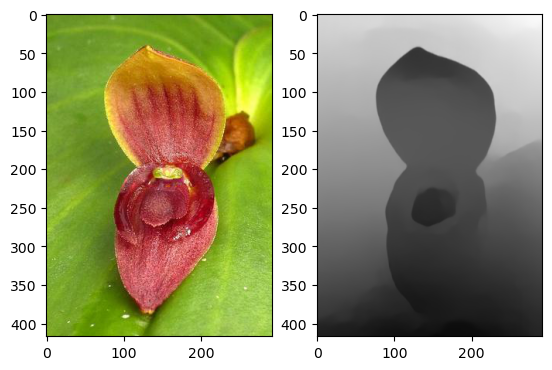

In [26]:
# this is how they (originally) looked from our simple class loader
fig,ax = plt.subplot_mosaic("AB")
ax["A"].imshow(loader[99]["mono"])
ax["B"].imshow(loader[99]["heat"],cmap="inferno")


In [28]:
# and thats it dataloader is done 😅
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4) # but an iterable.

In [29]:
for batch in dataloader:
    print(batch["mono"].shape)
    break

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/adi/opt/anaconda3/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/adi/opt/anaconda3/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'RedWebDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 